# Analysing features importance for game result


Analysis of the relationship between the **game stats and the result** and also the **impact of each individual player in the team results**

In [1]:
import os
import warnings
import tqdm
import pandas as pd
import numpy as np
from colour import Color

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path

from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve

from socceraction.spadl.wyscout import convert_to_spadl

pd.options.mode.chained_assignment = None
plt.style.use(['ggplot'])



## Load Data and Store in SPADL representation

Wyscout public data will be used (https://figshare.com/collections/Soccer_match_event_dataset/4415000).



In [2]:
#Code adapted from https://github.com/SciSports-Labs/fot-valuing-actions/blob/master/notebooks/tutorial1-run-pipeline.ipynb


def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

    
#Convert Teams data
json_teams = read_json_file('Bundesliga_data/teams.json')
df_teams = pd.read_json(json_teams)
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')


#Convert Players data
json_players = read_json_file('Bundesliga_data/players.json')
df_players = pd.read_json(json_players)
df_players.to_hdf('wyscout.h5', key='players', mode='a')


competition = 'Germany'


#Convert Matches data
file_matches = f'Bundesliga_data/matches_{competition}.json'
json_matches = read_json_file(file_matches)

df_matches = pd.read_json(json_matches)
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')


#Convert Events data
file_events = f'Bundesliga_data/events_{competition}.json'
json_events = read_json_file(file_events)
df_events = pd.read_json(json_events)
df_events_matches = df_events.groupby('matchId', as_index=False)
for match_id, df_events_match in df_events_matches:
    df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

convert_to_spadl('wyscout.h5', 'spadl.h5')



  0%|          | 0/306 [00:00<?, ?game/s]

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


  0%|          | 0/306 [00:00<?, ?game/s]

...Converting events to actions


100%|██████████| 306/306 [07:25<00:00,  1.46s/game]


In [2]:
df_games = pd.read_hdf('Bundesliga_data/spadl.h5', key='games')
df_players = pd.read_hdf('Bundesliga_data/spadl.h5', key='players')
df_teams = pd.read_hdf('Bundesliga_data/spadl.h5', key='teams')
df_players_games = pd.read_hdf('Bundesliga_data/spadl.h5', key='player_games')
df_results = pd.read_hdf('Bundesliga_data/spadl.h5', key='results')
df_actiontypes = pd.read_hdf('Bundesliga_data/spadl.h5', key='actiontypes')

dfs_events = []
#load feaures for a dataframe
for _, game in df_games.iterrows():
    game_id = game['game_id']
    
    #load all features for all actions of given game
    df_ev = pd.read_hdf('Bundesliga_data/spadl.h5', key=f'actions/game_{game_id}')
    df_ev['game_id'] = game_id
    dfs_events.append(df_ev)
    
#create df_features (for all actions)
dfs_events = pd.concat(dfs_events).reset_index(drop=True)
dfs_events = dfs_events.sort_values(by=["game_id", "period_id", "time_seconds"])

In [3]:
display(dfs_events.head())
dfs_events.shape

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id
388662,2516739,1.0,2.409746,2446.0,15231.0,52.5,34.00,52.50,32.64,0,0,1
388663,2516739,1.0,2.506082,2446.0,14786.0,52.5,32.64,81.90,14.96,0,0,1
388664,2516739,1.0,6.946706,2446.0,14803.0,81.9,14.96,98.70,31.28,0,0,1
388665,2516739,1.0,10.786491,2446.0,14768.0,98.7,31.28,84.00,6.80,0,0,1
388666,2516739,1.0,12.684514,2446.0,14803.0,84.0,6.80,76.65,2.72,0,0,1


(389993, 12)

### Relationship between the game stats and the result (goal difference)

In [5]:
#get stats

stats_df = dfs_events.pivot_table(values='result_id', index='game_id', columns='type_id', 
                         aggfunc='count').reset_index()

stats_df.fillna(0, inplace=True)
stats_df.set_index('game_id', inplace=True)

#stats_df.index.names = ['Games']
stats_df.head()

type_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,21,22
game_id,,,,,,,,,,,,,,,,,,
2516739,938.0,23.0,33.0,3.0,30.0,6.0,3.0,17.0,29.0,10.0,66.0,31.0,1.0,1.0,8.0,18.0,92.0,22.0
2516740,933.0,22.0,38.0,5.0,30.0,10.0,0.0,30.0,32.0,3.0,68.0,22.0,0.0,2.0,4.0,22.0,99.0,17.0
2516741,908.0,21.0,44.0,4.0,29.0,5.0,1.0,33.0,31.0,8.0,50.0,16.0,0.0,1.0,4.0,22.0,78.0,15.0
2516742,782.0,29.0,42.0,8.0,24.0,6.0,4.0,29.0,25.0,11.0,53.0,20.0,0.0,0.0,3.0,40.0,83.0,15.0
2516743,1011.0,34.0,37.0,3.0,26.0,7.0,1.0,38.0,24.0,10.0,76.0,31.0,0.0,1.0,9.0,14.0,92.0,18.0


In [8]:
#feature names
df_actiontypes

,type_id,type_name
0,0,pass
1,1,cross
2,2,throw_in
3,3,freekick_crossed
4,4,freekick_short
5,5,corner_crossed
6,6,corner_short
7,7,take_on
8,8,foul
9,9,tackle


In [6]:
# get goals difference

diff_series = pd.Series([])

for ind, g_events in dfs_events.groupby('game_id'):
    
    home_team = df_games[df_games['game_id'] == ind].iloc[0].home_team_id
    away_team = df_games[df_games['game_id'] == ind].iloc[0].away_team_id

    
    d = len(g_events[(g_events['team_id'] == home_team) & (g_events['type_id'].isin([11, 12, 13])) & (g_events['result_id'] == 1)])
    d -= len(g_events[(g_events['team_id'] == away_team) & (g_events['type_id'].isin([11, 12, 13])) & (g_events['result_id'] == 1)])
    
    diff_series = diff_series.append(pd.Series([d], index=[ind]))
stats_df['diff_goals'] = diff_series

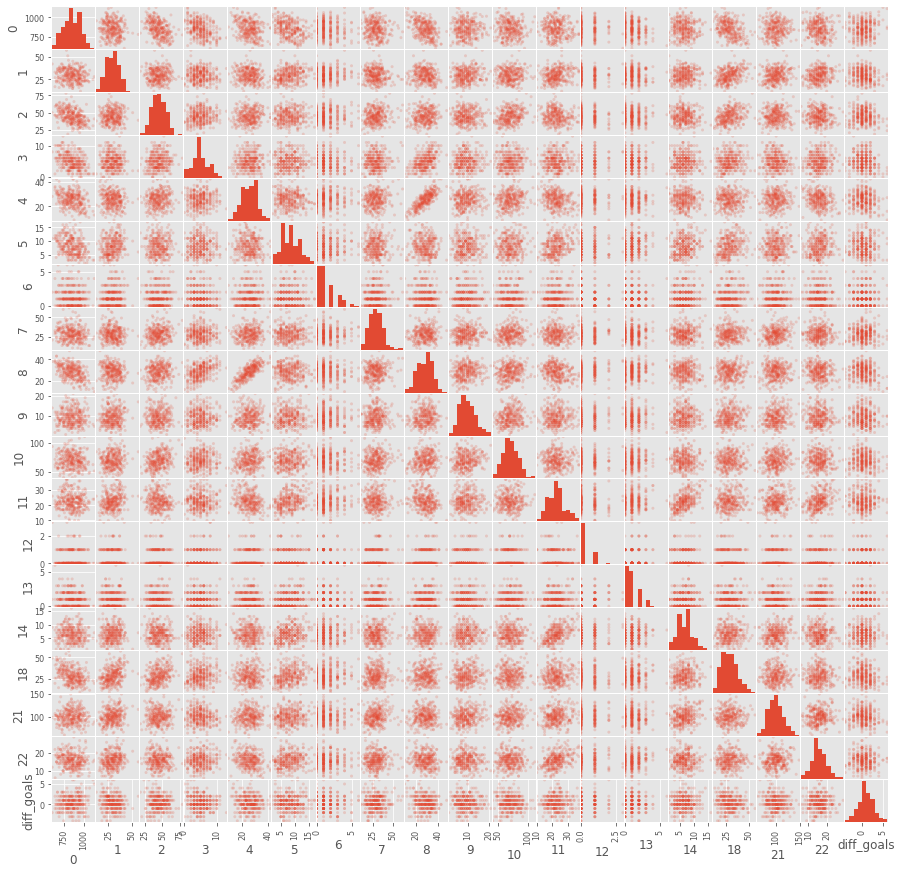

In [110]:

pd.plotting.scatter_matrix(stats_df, alpha=0.2, figsize = (15, 15))
plt.show()

From this plot, we can see that most of the features follow a normal distribution, but none of them as a clear linear or monotonic relationship with the goals difference in each game (see only last column or last row). Thus, none of the game stats is directly related to the goal difference.

**Number of shots vs Goals scored**

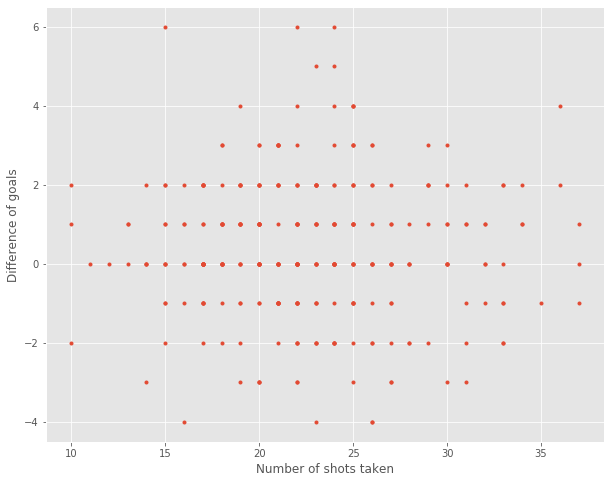

In [115]:
plt.figure(figsize=(10, 8))
plt.plot(stats_df[11], stats_df.diff_goals, '.')
plt.xlabel('Number of shots taken')
plt.ylabel('Difference of goals')
plt.show()

The general idea and belief amongst the team supporters is that a team who shoots more is closer to the victory, but by looking at the data, this is not true. As we can see, as the number of shots in a game increases the actual score does not increase, as there is not a linear or monotonic relationship between these two variables. Thus, this affirmation is not True.

### Impact of individual players in the team result (goal difference)

The minutes played by each player will be used to conclude which are more related to the teams victories.

In [62]:
#using borussia as example

borussia_id = df_teams[df_teams['short_team_name'] == 'Borussia Dortmund'].iloc[0].team_id

players_borussia = df_players_games[df_players_games['team_id'] == str(borussia_id)]

players_minutes = players_borussia.pivot_table(values='minutes_played', index='game_id', columns='player_id').reset_index()
players_minutes.fillna(0, inplace=True)
players_minutes.set_index('game_id', inplace=True)

players_minutes = players_minutes.round(2)

players_minutes.head()

player_id,3320,3335,14687,14770,14778,14789,14794,14798,14800,14801,...,224677,272363,297957,347366,356906,391530,397028,399599,447223,472696
game_id,,,,,,,,,,,,,,,,,,,,,
2516747,92.71,92.71,92.71,92.71,0.00,0.00,0.00,92.71,0.00,0.00,...,0.00,31.71,0.00,0.00,14.71,86.00,78.00,0.00,0.00,0.00
2516748,92.02,92.02,40.00,92.02,52.02,0.00,0.00,92.02,0.00,0.00,...,0.00,12.02,0.00,0.00,0.00,92.02,92.02,0.00,0.00,0.00
2516759,95.16,18.00,95.16,95.16,77.16,0.00,0.00,95.16,31.00,0.00,...,0.00,0.00,0.00,0.00,0.00,95.16,64.16,0.00,0.00,0.00
2516767,67.00,0.00,90.05,90.05,90.05,0.00,0.00,90.05,0.00,0.00,...,23.05,90.05,0.00,0.00,0.00,24.05,90.05,5.05,0.00,0.00
2516781,90.17,0.00,90.17,90.17,90.17,0.00,0.00,90.17,0.00,0.00,...,0.00,24.17,0.00,6.17,0.00,90.17,84.00,0.00,0.00,0.00
2516785,0.00,7.26,83.00,0.00,90.26,0.00,0.00,70.00,0.00,0.00,...,90.26,90.26,0.00,0.00,0.00,64.00,20.26,0.00,0.00,0.00
2516799,0.00,96.56,96.56,39.56,15.56,0.00,0.00,96.56,0.00,0.00,...,96.56,57.00,0.00,0.00,0.00,96.56,0.00,0.00,0.00,0.00
2516803,46.00,43.96,94.96,94.96,94.96,0.00,0.00,0.00,0.00,0.00,...,48.96,0.00,0.00,0.00,0.00,48.96,94.96,0.00,0.00,0.00
2516816,93.03,93.03,0.00,58.00,0.00,0.00,0.00,0.00,0.00,93.03,...,58.00,0.00,0.00,0.00,0.00,93.03,35.03,0.00,9.03,0.00


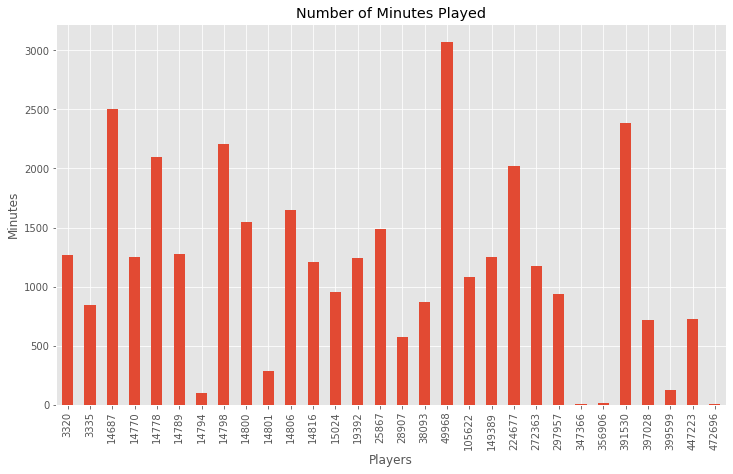

In [72]:
plt.figure(figsize = (12, 7))
players_minutes.sum().plot.bar()
plt.xlabel('Players')
plt.ylabel('Minutes')
plt.title('Number of Minutes Played')
plt.show()

We can see that the players with more minutes played are Burki (49968), Piszczek (14798) and Pulisic (391530)

In [87]:
# Add label to the dataframe (differece of goals)

players_minutes['diff_goals'] = diff_series

#transform diff_goals into binary: 1 - victory, 0 - draw or defeat
players_minutes['diff_goals'] = players_minutes['diff_goals'].apply(lambda x: 1 if x > 0 else 0)

players_minutes.head()

player_id,3320,3335,14687,14770,14778,14789,14794,14798,14800,14801,...,272363,297957,347366,356906,391530,397028,399599,447223,472696,diff_goals
game_id,,,,,,,,,,,,,,,,,,,,,
2516747,92.71,92.71,92.71,92.71,0.00,0.0,0.0,92.71,0.0,0.0,...,31.71,0.0,0.00,14.71,86.00,78.00,0.00,0.0,0.0,0
2516748,92.02,92.02,40.00,92.02,52.02,0.0,0.0,92.02,0.0,0.0,...,12.02,0.0,0.00,0.00,92.02,92.02,0.00,0.0,0.0,1
2516759,95.16,18.00,95.16,95.16,77.16,0.0,0.0,95.16,31.0,0.0,...,0.00,0.0,0.00,0.00,95.16,64.16,0.00,0.0,0.0,0
2516767,67.00,0.00,90.05,90.05,90.05,0.0,0.0,90.05,0.0,0.0,...,90.05,0.0,0.00,0.00,24.05,90.05,5.05,0.0,0.0,1
2516781,90.17,0.00,90.17,90.17,90.17,0.0,0.0,90.17,0.0,0.0,...,24.17,0.0,6.17,0.00,90.17,84.00,0.00,0.0,0.0,0


## Features Importance

In [119]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(players_minutes.drop(['diff_goals'], axis=1), players_minutes['diff_goals'])

players_importance = rf_model.feature_importances_
feature_names = [ df_players[df_players['player_id'] == i].iloc[0].short_name for i in players_minutes.columns[:-1].values]


/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


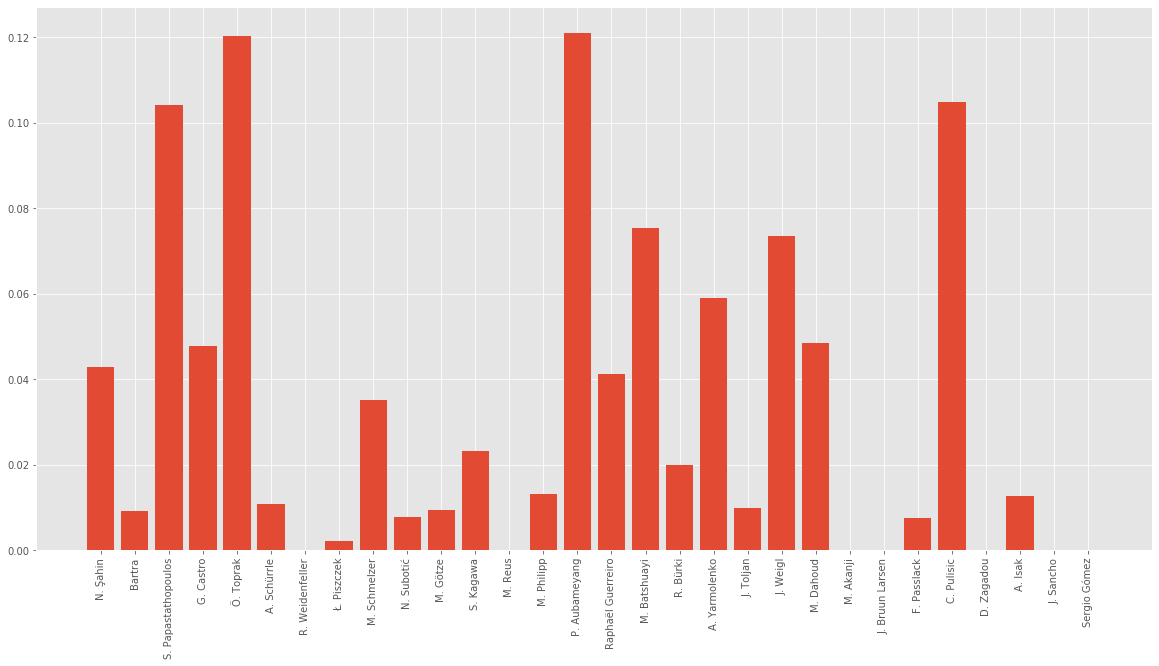

In [120]:
plt.figure(figsize=(20, 10))
plt.bar(feature_names, players_importance)
plt.xticks(rotation=90)
plt.show()

By looking at this bar plot, we can conclude that the that the players Sokratis, Toprak, Pulisic and Aubameyang are the most important for the match final result. As we can see, each of them, as an importance around 11% for the match outcome.